# The Prisoner Dilemma Game 

- Two players A and B

- Defining Actions of the game: 
  - C -> Cooperate
  - D -> Defect<br><br>

- Defining rewards of the game:
  - Both cooperate: $w$ and $w$
  - One cooperates, the other defects: $u$ and $z$
  - One defects, the other cooperates: $z$ and $u$
  - Both defect: $v$ and $v$<br><br>
  
<div style="text-align: left; margin-bottom: 50px;"> 
    
|        A\B              | Cooperate (C) | Defect (D)  |
|----------------------|-------------- |---------------|
| **Cooperate (C)**    | (w, w)        | (u, z)        |
| **Defect (D)**       | (z, u)        | (v, v)        |

   
</div>

- Necessary condition for Prisoner's Dilemma:
    - A1: $u < v < w < z$
    - A2: $2v < z+u < 2w$
- Waltman's nececessary conditions for cooperation in the
    - payoffs 
        - A3: w - v > 2 (v-u)
    - strategy and parameters:
        - A4: (Boltzmann strategy) or ($\epsilon$-greedy with low learning rate $\alpha$)

### 1. Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

### 2. Set the Game

In [2]:
# Parameter values :
u = 0
v = 1
w = 4
z = 5


print("A1 (dilemma): ",  u < v < w < z)
print("A2 (dilemma): ", 2*v < z+u < 2*w)
print("A3 (cooperation):", (w-v) > 2 *(v-u))


# Payoff matrices for Player A and Player B
payoffs = {
    "A": np.array([[w, u], [z, v]]), 
    "B": np.array([[w, z], [u, v]])
}

A1 (dilemma):  True
A2 (dilemma):  True
A3 (cooperation): True


### 3. Set the q-learning strategy

In [3]:
# Q-tables for both players
# One State
Q_A = np.zeros((2, 1))  
Q_B = np.zeros((2, 1))

In [4]:
# Q-learning parameters
alpha = 0.50  # Learning rate
initial_temperature = 10 # Temperature for exploration rate
decay_rate = 0.999994 # min exploration rate

# Simulation parameters
episodes = 500000


In [5]:
# Note: cooperation is such that agent chooses action 0

### Bolzmann strategy 

Agent chooses action $a = C, D$ with probability:

$$
P(A) = \frac{exp(\hat{Q}(a)/T)}{\sum_{a'} exp(\hat{Q}(a')/T)}
$$

where temperature decay rate follows

$$
T = T_0 \times \epsilon^{n} 
$$

where $n$ denotes episode


In [5]:
# Helper function for Boltzmann action selection
def choose_action(Q_column, temperature):

    # Flatten column in 1-dim vector
    Q_column = Q_column.flatten()
    
    # Calculate the probabilities of selecting each action using Boltzmann distribution
    exp_values = np.exp(Q_column / temperature)
    probabilities = exp_values / np.sum(exp_values)

    # Select an action based on the computed probabilities
    return np.random.choice(len(Q_column), p=probabilities)

In [6]:
# Temperature decay function
def temperature_decay(initial_temperature, decay_rate, episode):
    return initial_temperature * decay_rate ** episode

In [7]:
# Q-learning function
def play_game(alpha, initial_temperature, decay_rate):

    # Track simulations result regarding cooperation rates
    track_cooperation = []  
    coop_AB_count = 0

    for episode in range(1, episodes+1):
        # Decay epsilon
        temperature = temperature_decay(initial_temperature, decay_rate, episode)
    
        if temperature == 0.5*initial_temperature:
            print("Half decaying at episode n°", episode)
        
        # Choose actions
        action_A = choose_action(Q_A, temperature)
        action_B = choose_action(Q_B, temperature)
    
        # Count cooperation
        if action_A == 0 and action_B == 0:
            coop_AB_count += 1
        
        # Get rewards
        reward_A = payoffs["A"][action_A, action_B]
        reward_B = payoffs["B"][action_A, action_B]
        
        
        # Update Q-tables
        Q_A[action_A] += alpha * (reward_A  - Q_A[action_A])
        Q_B[action_B] += alpha * (reward_B  - Q_B[action_B])
    
        
        # Track cooperation every 1000 episodes
        if episode % 1000 == 0:
            track_cooperation.append({
                "episode": episode,
                "cooperation_AB": coop_AB_count / 1000
            })
            coop_AB_count = 0
    return track_cooperation

### 4. Test for one shot

In [42]:
%%time
data = play_game(alpha, initial_temperature, decay_rate)

CPU times: user 33.3 s, sys: 1.03 s, total: 34.4 s
Wall time: 33.5 s


In [32]:
# Convert cooperation tracking to DataFrame
track_cooperation_df = pd.DataFrame(data)

In [9]:
# Print Q-tables
print("Q-Table for Player A:")
print(Q_A)
print("\nQ-Table for Player B:")
print(Q_B)

Q-Table for Player A:
[[0.]
 [0.]]

Q-Table for Player B:
[[0.]
 [0.]]


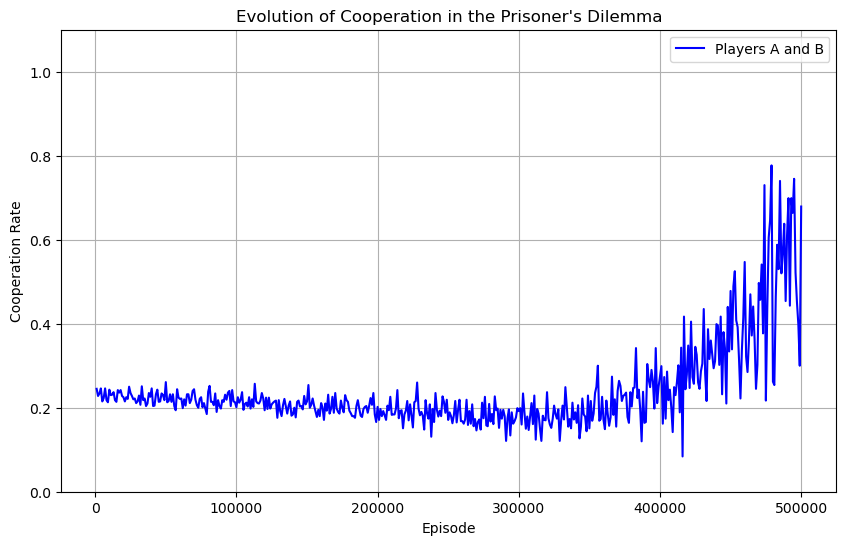

In [33]:
# Plot cooperation rates
plt.figure(figsize=(10, 6))
plt.ylim(0, 1.1)
plt.plot(track_cooperation_df["episode"], track_cooperation_df["cooperation_AB"], label="Players A and B", color="blue")
plt.title("Evolution of Cooperation in the Prisoner's Dilemma")
plt.xlabel("Episode")
plt.ylabel("Cooperation Rate")
plt.legend()
plt.grid(True)
plt.show()

### 5. Run several repetitions of the q-learning

In [8]:
%%time

# Define the number of repetitions
repetitions = 50

# Run play_game function 
def run_game(i):
    return play_game(alpha, initial_temperature, decay_rate)

# Use joblib to run `run_game` as parallel jobs
datasets = Parallel(n_jobs=-1)(delayed(run_game)(i) for i in range(1, repetitions + 1))


CPU times: user 120 ms, sys: 93.4 ms, total: 213 ms
Wall time: 1min 18s


In [9]:
# Combine the cooperation values across all datasets for each episode
episode_data = {}

# Loop through each dataset and accumulate the cooperation values
for data in datasets:
    for entry in data:
        episode = entry['episode']
        cooperation = entry['cooperation_AB']
        
        if episode not in episode_data:
            episode_data[episode] = []
        
        episode_data[episode].append(cooperation)

# Calculate the mean cooperation for each episode across all datasets
mean_cooperation = []
episodes = sorted(episode_data.keys())
for episode in episodes:
    mean_cooperation.append({'episode': episode, 'mean_cooperation_AB': sum(episode_data[episode]) / len(episode_data[episode])})

# Convert to DataFrame
df = pd.DataFrame(mean_cooperation)

# Calculate the moving average (window=3)
df['moving_avg'] = df['mean_cooperation_AB'].rolling(window=3).mean()

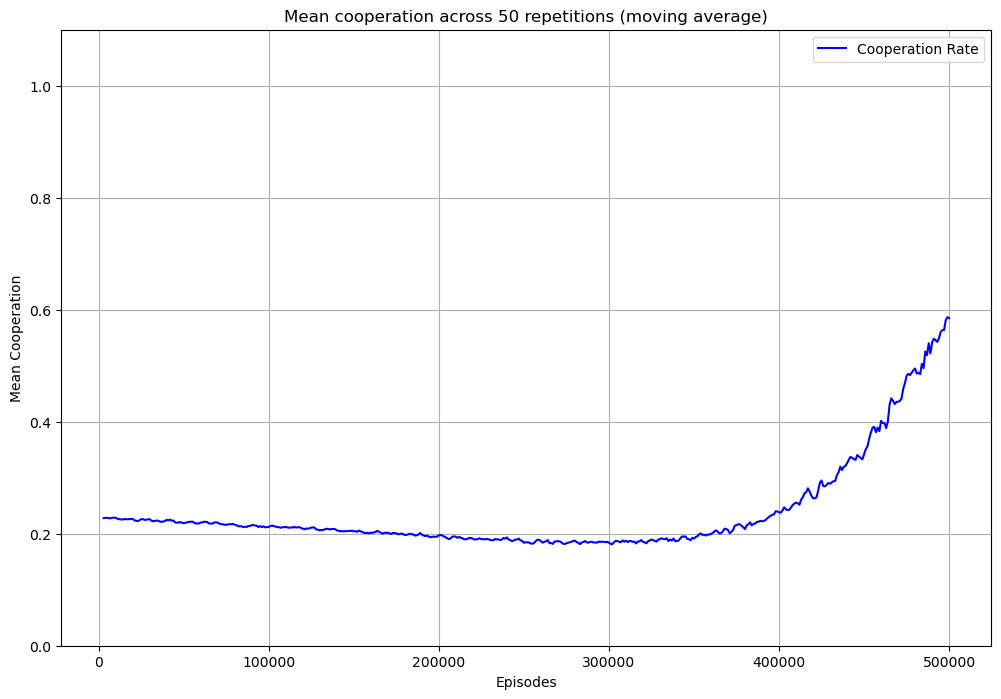

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(df['episode'], df['moving_avg'], label='Cooperation Rate', linestyle='-', color='blue')
plt.ylim(0, 1.1)
plt.xlabel('Episodes')
plt.ylabel('Mean Cooperation')
plt.title(f'Mean cooperation across {repetitions} repetitions (moving average)')
plt.legend()
plt.grid(True)
plt.show()